In [16]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

**Explanation**

- **Encoder**: The encoder will take the variable length input sequence and transform it into a fixed lengthed encoded hidden-state sequentially.

- **Decoder**: The decoder will predict the each successive target token given both the

  1. Input sequence
  2. Preceding tokens in the output

  On its own, the decoder is just a lambda language model which spits out tokens

**Teacher Forcing**
This is an approach of running the decoder especially on input and output which are fed into the decoder during training and test

- The special `<bos>` token and the original target sequence(token labels), excluding `<eos>`, are concatenated as input to the decoder, **WHILE** the decoder output (labels for training) is the original target sequence shifted by one token.


**Encoder**

- Transforms the var-length input into a fixed-shape _context variable_ `c`

- Considering the single batch input sequence `x1, ..., xT`. At `t` time, the encoder RNN transforms the input feauture xt and the previous hidden state `h(t-1)` into the current hidden state `ht`

  **ht = f(xt, ht-1)**

- I ngeneral the encoder transforms al lthe hidden states `h1,...,hT` into a contecxt variable through a customized function q.

  **c = q(h1, ..., hT)**

- We use an _embedding layer_ to obtain the feature vector for each token in the input sequence. The embedding layer is just a lookup table that takes indices and returns words or tokens corresponding.
  The weight matrix of an embedding layer has:

  `#rows = vocab_size`

  `#columns = feature vector dimensions i.e embedding_size`


In [17]:
def init_seq2seq(module):  # @save
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

In [18]:
class Seq2SeqEncoder(d2l.Encoder):  # @save
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X has shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [19]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))

In [20]:
d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))

**Decoder**

- Given a target output `y1,...,yT` (NB: T of output must not be same as the input sequence), the decoder assigns a probability to each possible token yt+1, conditioned upon the previous tokens in the target y1, ..., yt and the context variable `c`

  `i.e P(yt+1 | y1, ..., yt, c)`

- To predict the next token t+1 in the target sequence, the RNN decoder takes the previous steps token `yt`, the RNN hidden state fro mthe previous step `st-1` and the context variable `c` and transforms them into the current hidden state `st` using a transformation `g`.

  `i.e st = g(yt-1, c, st-1) `

- We use the hidden state of the encoder at the final time step of the encoder to initialize the hidden state of the decoder.

- The above requires the encoder RNN and decoder RNN to hav eth same number of layers and hidden units.

- **All in All** To predice the probability distribution of the output token, we use a fully connected layer to transform the hidden state at the final layer of the RNN decoder


In [21]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hidden)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

In [22]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

/home/sih/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [23]:
class Seq2Seq(d2l.EncoderDecoder):  # @save
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot("loss", self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        """Adam optimization used"""
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [24]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    """We use the softmaz to obtain the distribution oand calculate the creoss entropy loss for the optimization
    But we ignore all the padding tokens in the loss calculation but multiplying them by zero
    """
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    # Masks out padding tokens by multiplying them by 0
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()

**Training**


In [25]:
@d2l.add_to_class(d2l.MTFraEng)
def _download(self):
    """Since I downloaded it manually"""
    # d2l.extract(d2l.download(
    #     d2l.DATA_URL+'fra-eng.zip', self.root,
    #     '94646ad1522d915e7b0f9296181140edcf86a4f5'))
    with open(self.root + "/fra-eng/fra.txt", encoding="utf-8") as f:
        return f.read()

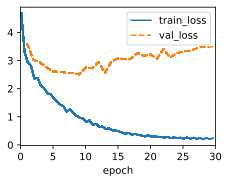

In [26]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2

encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout
)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout
)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab["<pad>"], lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

**Prediction - Method 1**

At each step of the prediction of an output sequence, the predicted token from the previous time step is fed into the decoder as an input.

- At the initial step the `<bos>` token is fed into the decoder. At the end of prediction, the decoder emit the `<eos>`


In [34]:
@d2l.add_to_class(d2l.EncoderDecoder)  # @save
def predict_step(self, batch, device, num_steps, save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)

    outputs, attention_weights = [
        tgt[:, (0)].unsqueeze(1),
    ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save the attension weights 
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights

In [35]:
def bleu(pred_seq, label_seq, k):  # @save
    """
    Compute the BLEU: Bilingual Evaluation Understudy to measure the similarity between the target sequence and the prediction

    For any n-gram in the predicted sequence, BLEU evaluates whether this n-gram appears in the target sequence.

    p(n) is the prcision of an n-gram i.e the number of matched n-grams in the predicted sequence over the number of all the n-grams in the target one

    BLEU aggregates this until the longest n-gram, and assigns weight to each precision. Because matching longer n-grams means better prediction, more weight
    is assigned to longer n-grams than shorter.

    """
    pred_tokens, label_tokens = pred_seq.split(" "), label_seq.split(" ")
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[" ".join(label_tokens[i : i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[" ".join(pred_tokens[i : i + n])] > 0:
                num_matches += 1
                label_subs[" ".join(pred_tokens[i : i + n])] -= 1
            score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [36]:
engs = ["go .", "i lost .", "he's calm .", "i'm home ."]
fras = ["va !", "j'ai perdu .", "il est calme .", "je suis chez moi ."]
preds, _ = model.predict_step(data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == "<eos>":
            break
        translation.append(token)
    print(f"{en} => {translation}, bleu," f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,0.707
i lost . => ["j'ai", 'perdu', '.'], bleu,0.396
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.095
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,0.108
